# Covid data wrangling

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import datetime

Covid dataset source [https://github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/)

### Read URL, getting data from web
- Pull information from web and store it as a dataframe.

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data_org = pd.read_csv(url)
data_org.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/9/22,8/10/22,8/11/22,8/12/22,8/13/22,8/14/22,8/15/22,8/16/22,8/17/22,8/18/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,187966,188202,188506,188704,188820,189045,189343,189477,189710,190010
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,318638,319444,320086,320781,321345,321804,322125,322837,323282,323829
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,268478,268584,268718,268866,269008,269141,269269,269381,269473,269556
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,45793,45899,45899,45899,45899,45899,45899,45899,45975,45975
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,102636,102636,102636,102636,102636,102636,102636,102636,102636,102636


In [3]:
data_org.shape

(285, 944)

In [4]:
data_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Columns: 944 entries, Province/State to 8/18/22
dtypes: float64(2), int64(940), object(2)
memory usage: 2.1+ MB


In [5]:
data_org.describe(include = 'object')

,Province/State,Country/Region
count,89,285
unique,89,199
top,Australian Capital Territory,China
freq,1,34


## Melt Data (wide format -> Long format)

- melt() function will collapse all the columns into a single column here named as variable.
- can be verified using head and tail on variable column, as all col's from Province to date is put into 1 long format.

In [6]:
data = data_org.melt()
data.head()

,variable,value
0,Province/State,NaN
1,Province/State,NaN
2,Province/State,NaN
3,Province/State,NaN
4,Province/State,NaN


In [7]:
data.tail()

,variable,value
269035,8/18/22,697447
269036,8/18/22,535
269037,8/18/22,11914
269038,8/18/22,332264
269039,8/18/22,256579


In [8]:
data.shape

(269040, 2)

- We want to melt only the date column, rest all columns we want to retain like 'Province/State', 'Country/Region', 'Lat', 'Long'
- Columns mentioned under id_vars argument inside melt function will be retained, rest will be melted.
- For columns which get melted will be under variable column & their value counts will be under value column.

In [9]:
cols_retain = ['Province/State', 'Country/Region', 'Lat', 'Long']
data = data_org.melt(id_vars=cols_retain)
data.head()

,Province/State,Country/Region,Lat,Long,variable,value
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


- Rename col's 'variable' and 'value' which r default names used by melt function to 'Date' and 'confirmed cases'.
- Wide format is changed to long format here (for dates columns)

### For certain analysis long format is good e.g. like storing in a db while for some analysis wide format is good e.g. crosstab analysis / pivot.

In [10]:
cols_retain = ['Province/State', 'Country/Region', 'Lat', 'Long']
data = data_org.melt(id_vars=cols_retain)
data = data.rename(columns={'variable': 'Date', 'value': 'confirmed'})
data.head()

,Province/State,Country/Region,Lat,Long,Date,confirmed
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


Convert Date column to datetime data type

In [11]:
data['Date'].dtype

dtype('O')

In [12]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
data['Date'].head()

0   2020-01-22
1   2020-01-22
2   2020-01-22
3   2020-01-22
4   2020-01-22
Name: Date, dtype: datetime64[ns]

Check time period of data using min & max

In [13]:
data['Date'].min(), data['Date'].max()      # 2020 to 2022, URL picking data till current date

(Timestamp('2020-01-22 00:00:00'), Timestamp('2022-08-18 00:00:00'))

- Check for missing values
- Since some countries report data only country wise & not province/state wise hence lot of missing data. e.g. Afganistan, Albania etc report only at country level.
- Because of huge data missing from Province/State we can drop this column however granularity of data will change in this case so we need to use groupby 'Country' and 'Date' & aggregate by 'confirmed cases' if plan to drop province column.

In [14]:
data.isna().sum() / data.shape[0] * 100

Province/State    68.771930
Country/Region     0.000000
Lat                0.701754
Long               0.701754
Date               0.000000
confirmed          0.000000
dtype: float64

In [15]:
data[data['Province/State'].isna()]

,Province/State,Country/Region,Lat,Long,Date,confirmed
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0
...,...,...,...,...,...,...
267895,NaN,West Bank and Gaza,31.952200,35.233200,2022-08-18,697447
267896,NaN,Winter Olympics 2022,39.904200,116.407400,2022-08-18,535
267897,NaN,Yemen,15.552727,48.516388,2022-08-18,11914
267898,NaN,Zambia,-13.133897,27.849332,2022-08-18,332264


- Check for rows that are not-null in Province/State column
- Countries like Australia, UK provide data at province level.

In [16]:
data[~data['Province/State'].isna()]   # extract rows where 'Province/State' is not null

,Province/State,Country/Region,Lat,Long,Date,confirmed
9,Australian Capital Territory,Australia,-35.473500,149.012400,2020-01-22,0
10,New South Wales,Australia,-33.868800,151.209300,2020-01-22,0
11,Northern Territory,Australia,-12.463400,130.845600,2020-01-22,0
12,Queensland,Australia,-27.469800,153.025100,2020-01-22,0
13,South Australia,Australia,-34.928500,138.600700,2020-01-22,0
...,...,...,...,...,...,...
267884,Isle of Man,United Kingdom,54.236100,-4.548100,2022-08-18,37794
267885,Jersey,United Kingdom,49.213800,-2.135800,2022-08-18,58536
267886,Montserrat,United Kingdom,16.742498,-62.187366,2022-08-18,1106
267887,"Saint Helena, Ascension and Tristan da Cunha",United Kingdom,-7.946700,-14.355900,2022-08-18,4


## To change granularity of dataset
### Groupby 'Country/Region', 'Date' and aggregate on confirmed cases and for latitude & longitude just take 1st value as we cannot aggregate on Lat/Long

In [17]:
data_country = data.groupby(['Country/Region', 'Date']).agg({'confirmed': sum,
                                                             'Lat': 'first',
                                                             'Long': 'first'})
data_country.head()

confirmed       Lat       Long
Country/Region Date                                      
Afghanistan    2020-01-22          0  33.93911  67.709953
               2020-01-23          0  33.93911  67.709953
               2020-01-24          0  33.93911  67.709953
               2020-01-25          0  33.93911  67.709953
               2020-01-26          0  33.93911  67.709953

In [18]:
data_country.tail()

confirmed        Lat       Long
Country/Region Date                                       
Zimbabwe       2022-08-14     256539 -19.015438  29.154857
               2022-08-15     256544 -19.015438  29.154857
               2022-08-16     256561 -19.015438  29.154857
               2022-08-17     256565 -19.015438  29.154857
               2022-08-18     256579 -19.015438  29.154857

In [19]:
data_country = data_country.reset_index()
data_country.head()

,Country/Region,Date,confirmed,Lat,Long
0,Afghanistan,2020-01-22,0,33.93911,67.709953
1,Afghanistan,2020-01-23,0,33.93911,67.709953
2,Afghanistan,2020-01-24,0,33.93911,67.709953
3,Afghanistan,2020-01-25,0,33.93911,67.709953
4,Afghanistan,2020-01-26,0,33.93911,67.709953


In [20]:
data_country.tail()

,Country/Region,Date,confirmed,Lat,Long
187055,Zimbabwe,2022-08-14,256539,-19.015438,29.154857
187056,Zimbabwe,2022-08-15,256544,-19.015438,29.154857
187057,Zimbabwe,2022-08-16,256561,-19.015438,29.154857
187058,Zimbabwe,2022-08-17,256565,-19.015438,29.154857
187059,Zimbabwe,2022-08-18,256579,-19.015438,29.154857


In [21]:
print('Size of original dataset',data.shape)
print('\nSize of dataset after granularity changed from state to country',data_country.shape)

Size of original dataset (267900, 6)

Size of dataset after granularity changed from state to country (187060, 5)


To check/confirm that each country has only 1 row for 1 date

In [22]:
data_country[data_country['Date'] == data_country['Date'].max()]['Country/Region'].value_counts()

Afghanistan    1
Namibia        1
Netherlands    1
New Zealand    1
Nicaragua      1
              ..
Greece         1
Grenada        1
Guatemala      1
Guinea         1
Zimbabwe       1
Name: Country/Region, Length: 199, dtype: int64

### Plot confirmed covid cases only for 'India'.

### Here in confirmed cases it is not absolute count, it is cumulative count hence shows only up direction (previous cases added to calculate the next number)

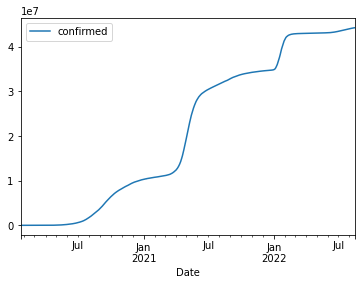

In [31]:
data_country[data_country['Country/Region'] == 'India'].plot.line(x='Date', y='confirmed');

## Below custom function with all steps executed above for data wrangling - so can replicate for death cases as well as recovered cases apart from confirmed cases.
- Extraction of data (from url)
- Reshape of data (from wide to long format)
- Granularity change (from state to country level)

In [24]:
def extract_wrangle_data(variable_type):
    # Extract data
    base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19'
    url = base_url + '_%s_global.csv' % variable_type
    data_org = pd.read_csv(url)
    
    # Reshape (wide -> long)
    cols_retain = ['Province/State', 'Country/Region', 'Lat', 'Long']
    data = data_org.melt(id_vars=cols_retain)
    data = data.rename(columns={'variable': 'Date', 'value': variable_type})
    data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
    
    # Change granularity
    data_country = data.groupby(['Country/Region', 'Date']).agg({variable_type: sum,
                                                             'Lat': 'first',
                                                             'Long': 'first'})
    data_country = data_country.reset_index()
    return data_country

In [25]:
confirmed = extract_wrangle_data('confirmed')
deaths = extract_wrangle_data('deaths')
recovered = extract_wrangle_data('recovered')

In [26]:
confirmed.head()

,Country/Region,Date,confirmed,Lat,Long
0,Afghanistan,2020-01-22,0,33.93911,67.709953
1,Afghanistan,2020-01-23,0,33.93911,67.709953
2,Afghanistan,2020-01-24,0,33.93911,67.709953
3,Afghanistan,2020-01-25,0,33.93911,67.709953
4,Afghanistan,2020-01-26,0,33.93911,67.709953


In [27]:
recovered.head()

,Country/Region,Date,recovered,Lat,Long
0,Afghanistan,2020-01-22,0,33.93911,67.709953
1,Afghanistan,2020-01-23,0,33.93911,67.709953
2,Afghanistan,2020-01-24,0,33.93911,67.709953
3,Afghanistan,2020-01-25,0,33.93911,67.709953
4,Afghanistan,2020-01-26,0,33.93911,67.709953


In [28]:
deaths.head()

,Country/Region,Date,deaths,Lat,Long
0,Afghanistan,2020-01-22,0,33.93911,67.709953
1,Afghanistan,2020-01-23,0,33.93911,67.709953
2,Afghanistan,2020-01-24,0,33.93911,67.709953
3,Afghanistan,2020-01-25,0,33.93911,67.709953
4,Afghanistan,2020-01-26,0,33.93911,67.709953


**Merging Confirmed, Deaths and Recovered Dataframes based on common columns- Country/Region', 'Date', 'Lat', 'Long**

In [29]:
common_columns = ['Country/Region', 'Date', 'Lat', 'Long']
data_final = confirmed.merge(deaths, on=common_columns, how='inner').merge(recovered, on=common_columns, how='inner')
data_final.head()

,Country/Region,Date,confirmed,Lat,Long,deaths,recovered
0,Afghanistan,2020-01-22,0,33.93911,67.709953,0,0
1,Afghanistan,2020-01-23,0,33.93911,67.709953,0,0
2,Afghanistan,2020-01-24,0,33.93911,67.709953,0,0
3,Afghanistan,2020-01-25,0,33.93911,67.709953,0,0
4,Afghanistan,2020-01-26,0,33.93911,67.709953,0,0


In [30]:
data_final.tail()

,Country/Region,Date,confirmed,Lat,Long,deaths,recovered
183295,Zimbabwe,2022-08-14,256539,-19.015438,29.154857,5588,0
183296,Zimbabwe,2022-08-15,256544,-19.015438,29.154857,5588,0
183297,Zimbabwe,2022-08-16,256561,-19.015438,29.154857,5588,0
183298,Zimbabwe,2022-08-17,256565,-19.015438,29.154857,5588,0
183299,Zimbabwe,2022-08-18,256579,-19.015438,29.154857,5589,0


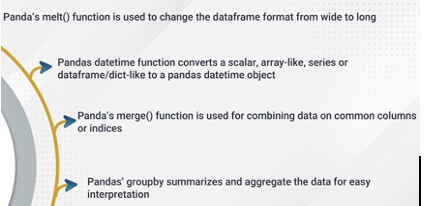